In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.1 MB/s eta 0:00:00


In [ ]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U langchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install docarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00


# LangChain: Evaluation

## Outline:

* Example generation
* Manual evaluation (and debuging)
* LLM-assisted evaluation

In [ ]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

## Create our QandA application

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch

In [ ]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
data = loader.load()

In [ ]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [ ]:
llm = ChatOpenAI(temperature = 0.0)
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=index.vectorstore.as_retriever(),
    verbose=True,
    chain_type_kwargs = {
        "document_separator": "<<<<>>>>>"
    }
)

### Coming up with test datapoints

In [ ]:
data[10]

Document(page_content=": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded hem.\n- Pull-on pants have a wide elastic waistband and drawstring, side pockets and a modern slim leg.\n\nImported.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 10})

In [ ]:
data[11]

Document(page_content=': 11\nname: Ultra-Lofty 850 Stretch Down Hooded Jacket\ndescription: This technical stretch down jacket from our DownTek collection is sure to keep you warm and comfortable with its full-stretch construction providing exceptional range of motion. With a slightly fitted style that falls at the hip and best with a midweight layer, this jacket is suitable for light activity up to 20° and moderate activity up to -30°. The soft and durable 100% polyester shell offers complete windproof protection and is insulated with warm, lofty goose down. Other features include welded baffles for a no-stitch construction and excellent stretch, an adjustable hood, an interior media port and mesh stash pocket and a hem drawcord. Machine wash and dry. Imported.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 11})

### Hard-coded examples

In [ ]:
examples = [
    {
        "query": "Do the Cozy Comfort Pullover Set\
        have side pockets?",
        "answer": "Yes"
    },
    {
        "query": "What collection is the Ultra-Lofty \
        850 Stretch Down Hooded Jacket from?",
        "answer": "The DownTek collection"
    }
]

### LLM-Generated examples

In [ ]:
from langchain.evaluation.qa import QAGenerateChain

example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI())

new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in data[:5]]
)

new_examples[0]

{'query': "What is the weight of each pair of Women's Campside Oxfords?",
 'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb.1 oz."}

In [ ]:
data[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

### Combine examples

In [ ]:
examples += new_examples
qa.run(examples[0]["query"])



> Entering new  chain...

> Finished chain.


'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'

## Manual Evaluation

In [ ]:
import langchain
langchain.debug = True
qa.run(examples[0]["query"])

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Do the Cozy Comfort Pullover Set        have side pockets?"
}
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] Entering Chain run with input:
{
  "question": "Do the Cozy Comfort Pullover Set        have side pockets?",
  "context": ": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded h

'The Cozy Comfort Pullover Set, Stripe has side pockets.'

In [ ]:
# Turn off the debug mode
langchain.debug = False

## LLM assisted evaluation

In [ ]:
predictions = qa.apply(examples)



> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


In [ ]:
from langchain.evaluation.qa import QAEvalChain

llm = ChatOpenAI(temperature=0)
eval_chain = QAEvalChain.from_llm(llm)

graded_outputs = eval_chain.evaluate(examples, predictions)

for i, eg in enumerate(examples):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer'])
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['text'])
    print()

Example 0:
Question: Do the Cozy Comfort Pullover Set        have side pockets?
Real Answer: Yes
Predicted Answer: The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.
Predicted Grade: CORRECT

Example 1:
Question: What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?
Real Answer: The DownTek collection
Predicted Answer: The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.
Predicted Grade: CORRECT

Example 2:
Question: What is the weight of each pair of Women's Campside Oxfords?
Real Answer: The approximate weight of each pair of Women's Campside Oxfords is 1 lb.1 oz.
Predicted Answer: The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.
Predicted Grade: CORRECT

Example 3:
Question: What are the dimensions of the small and medium Recycled Waterhog Dog Mat?
Real Answer: The dimensions of the small Recycled Waterhog Dog Mat are 18" x 28" and the dimensions of the medium mat are 22.5" 

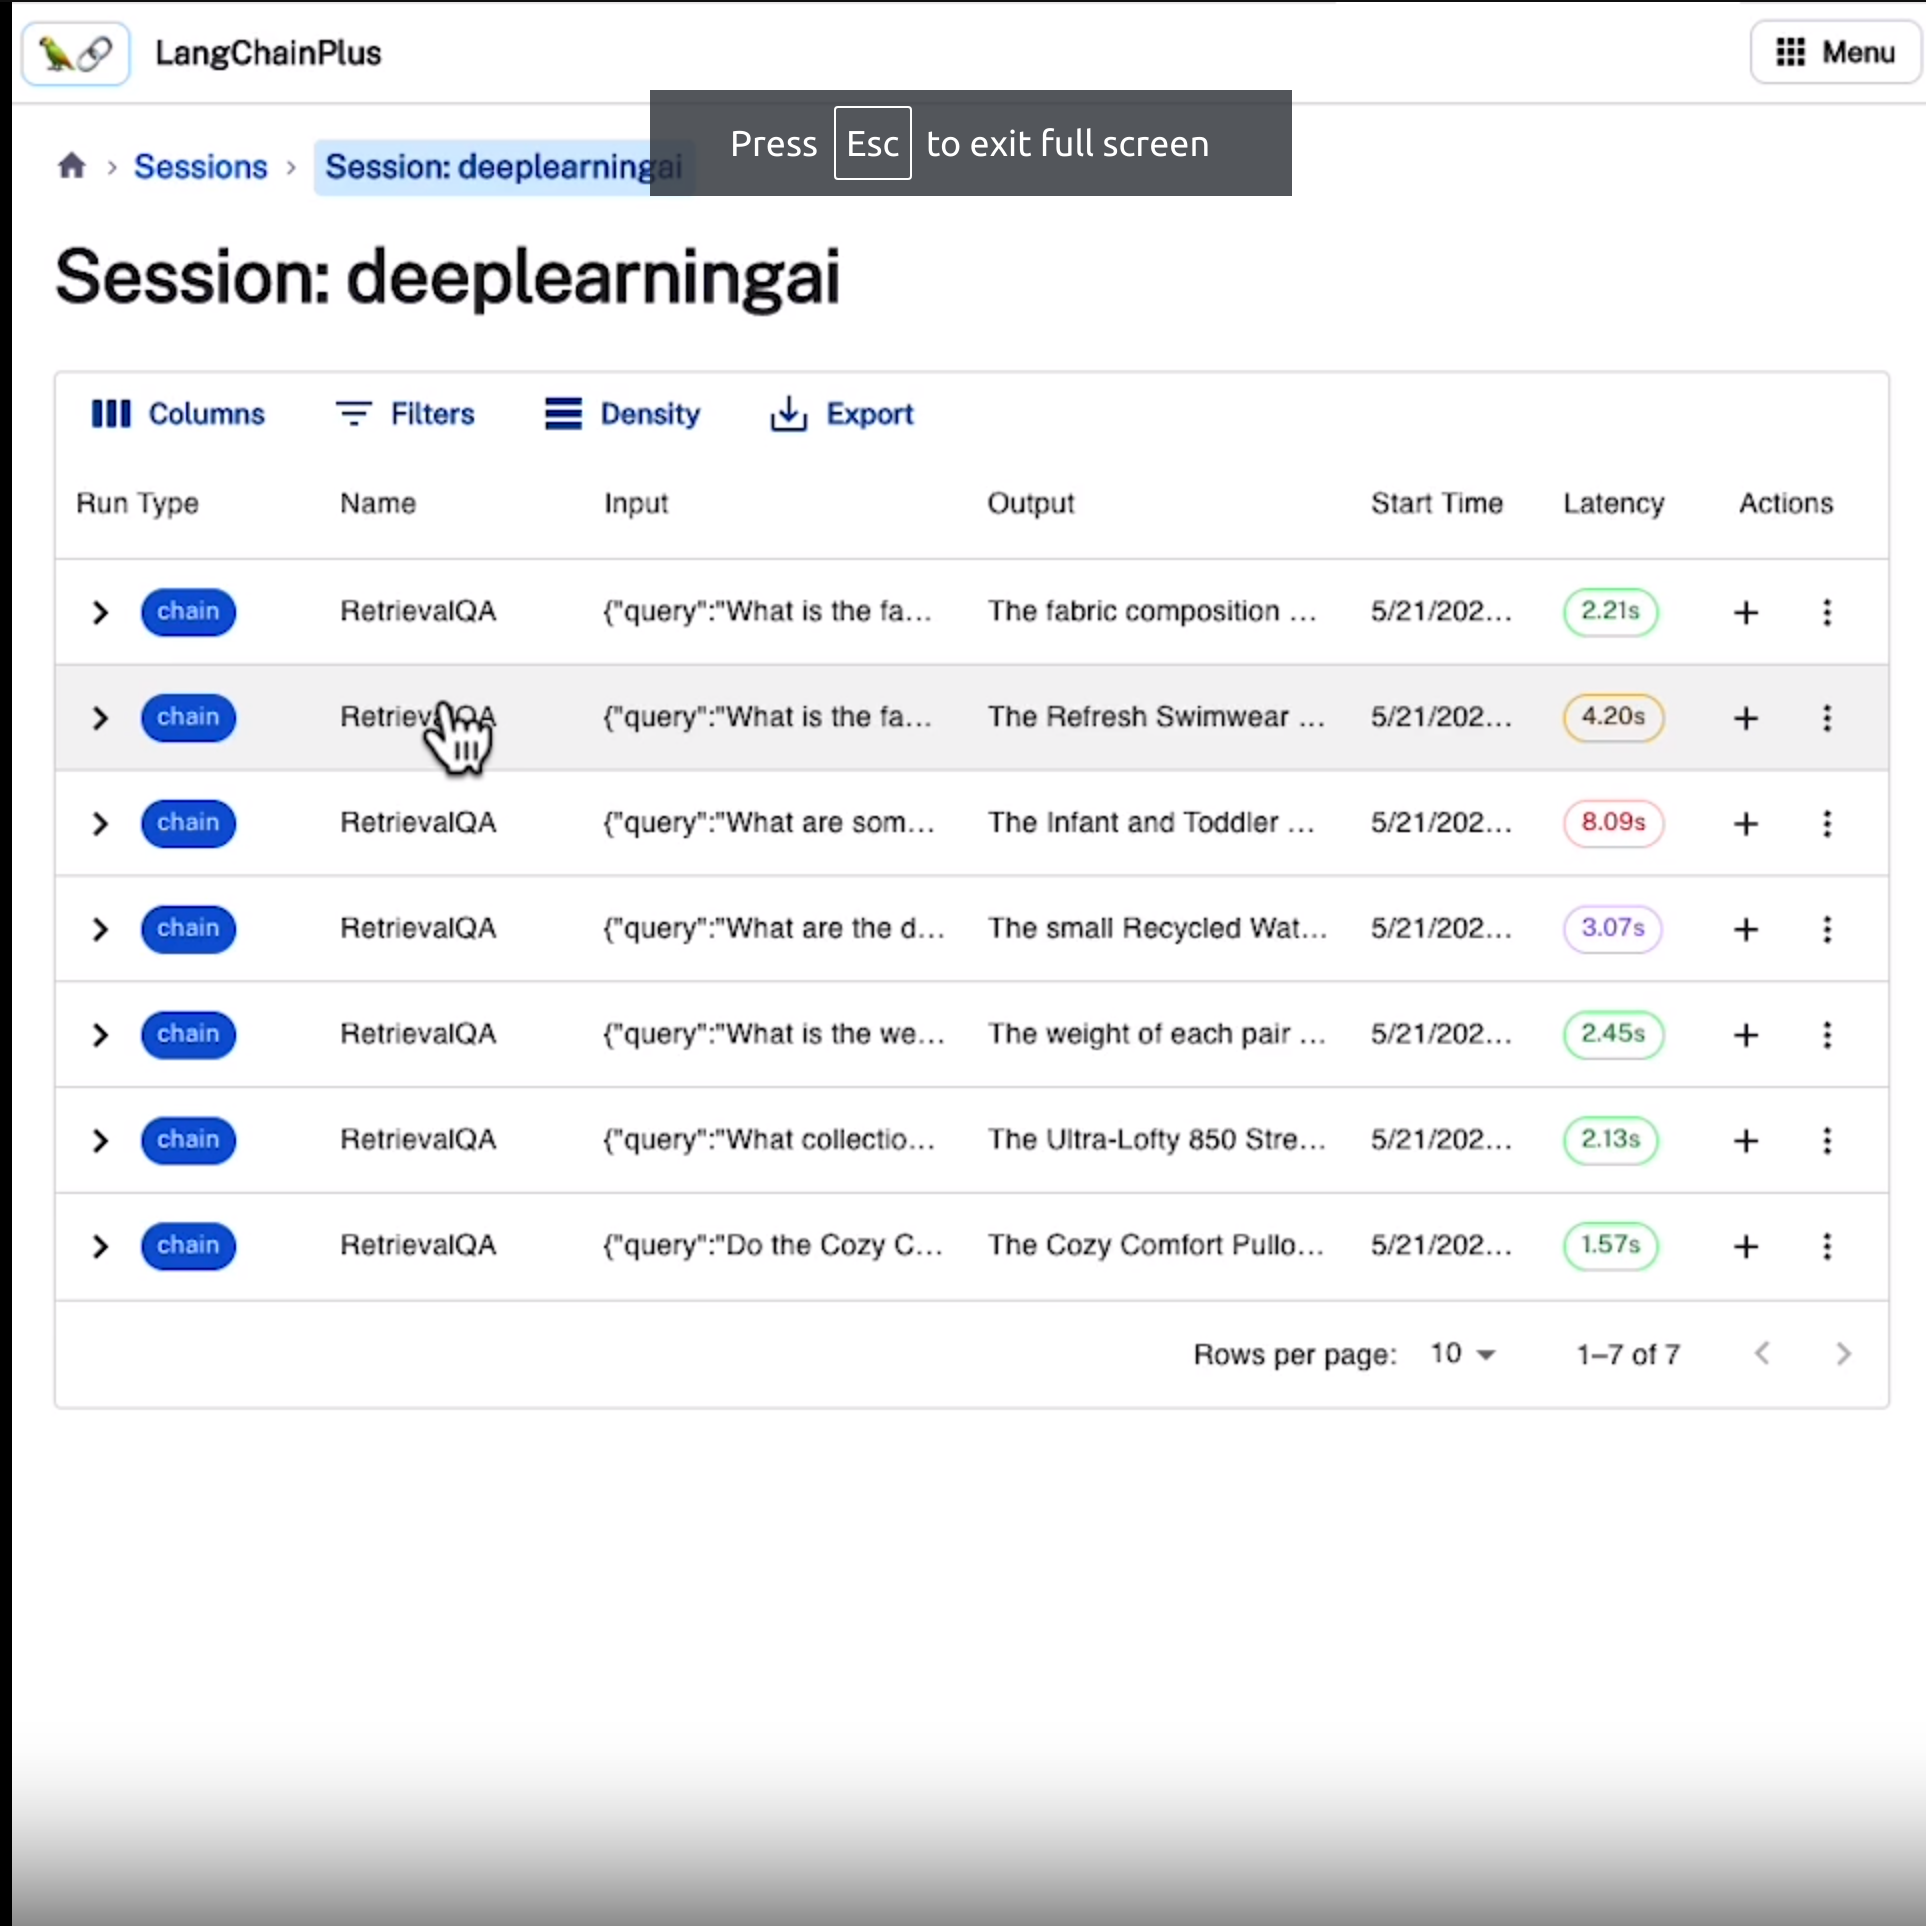

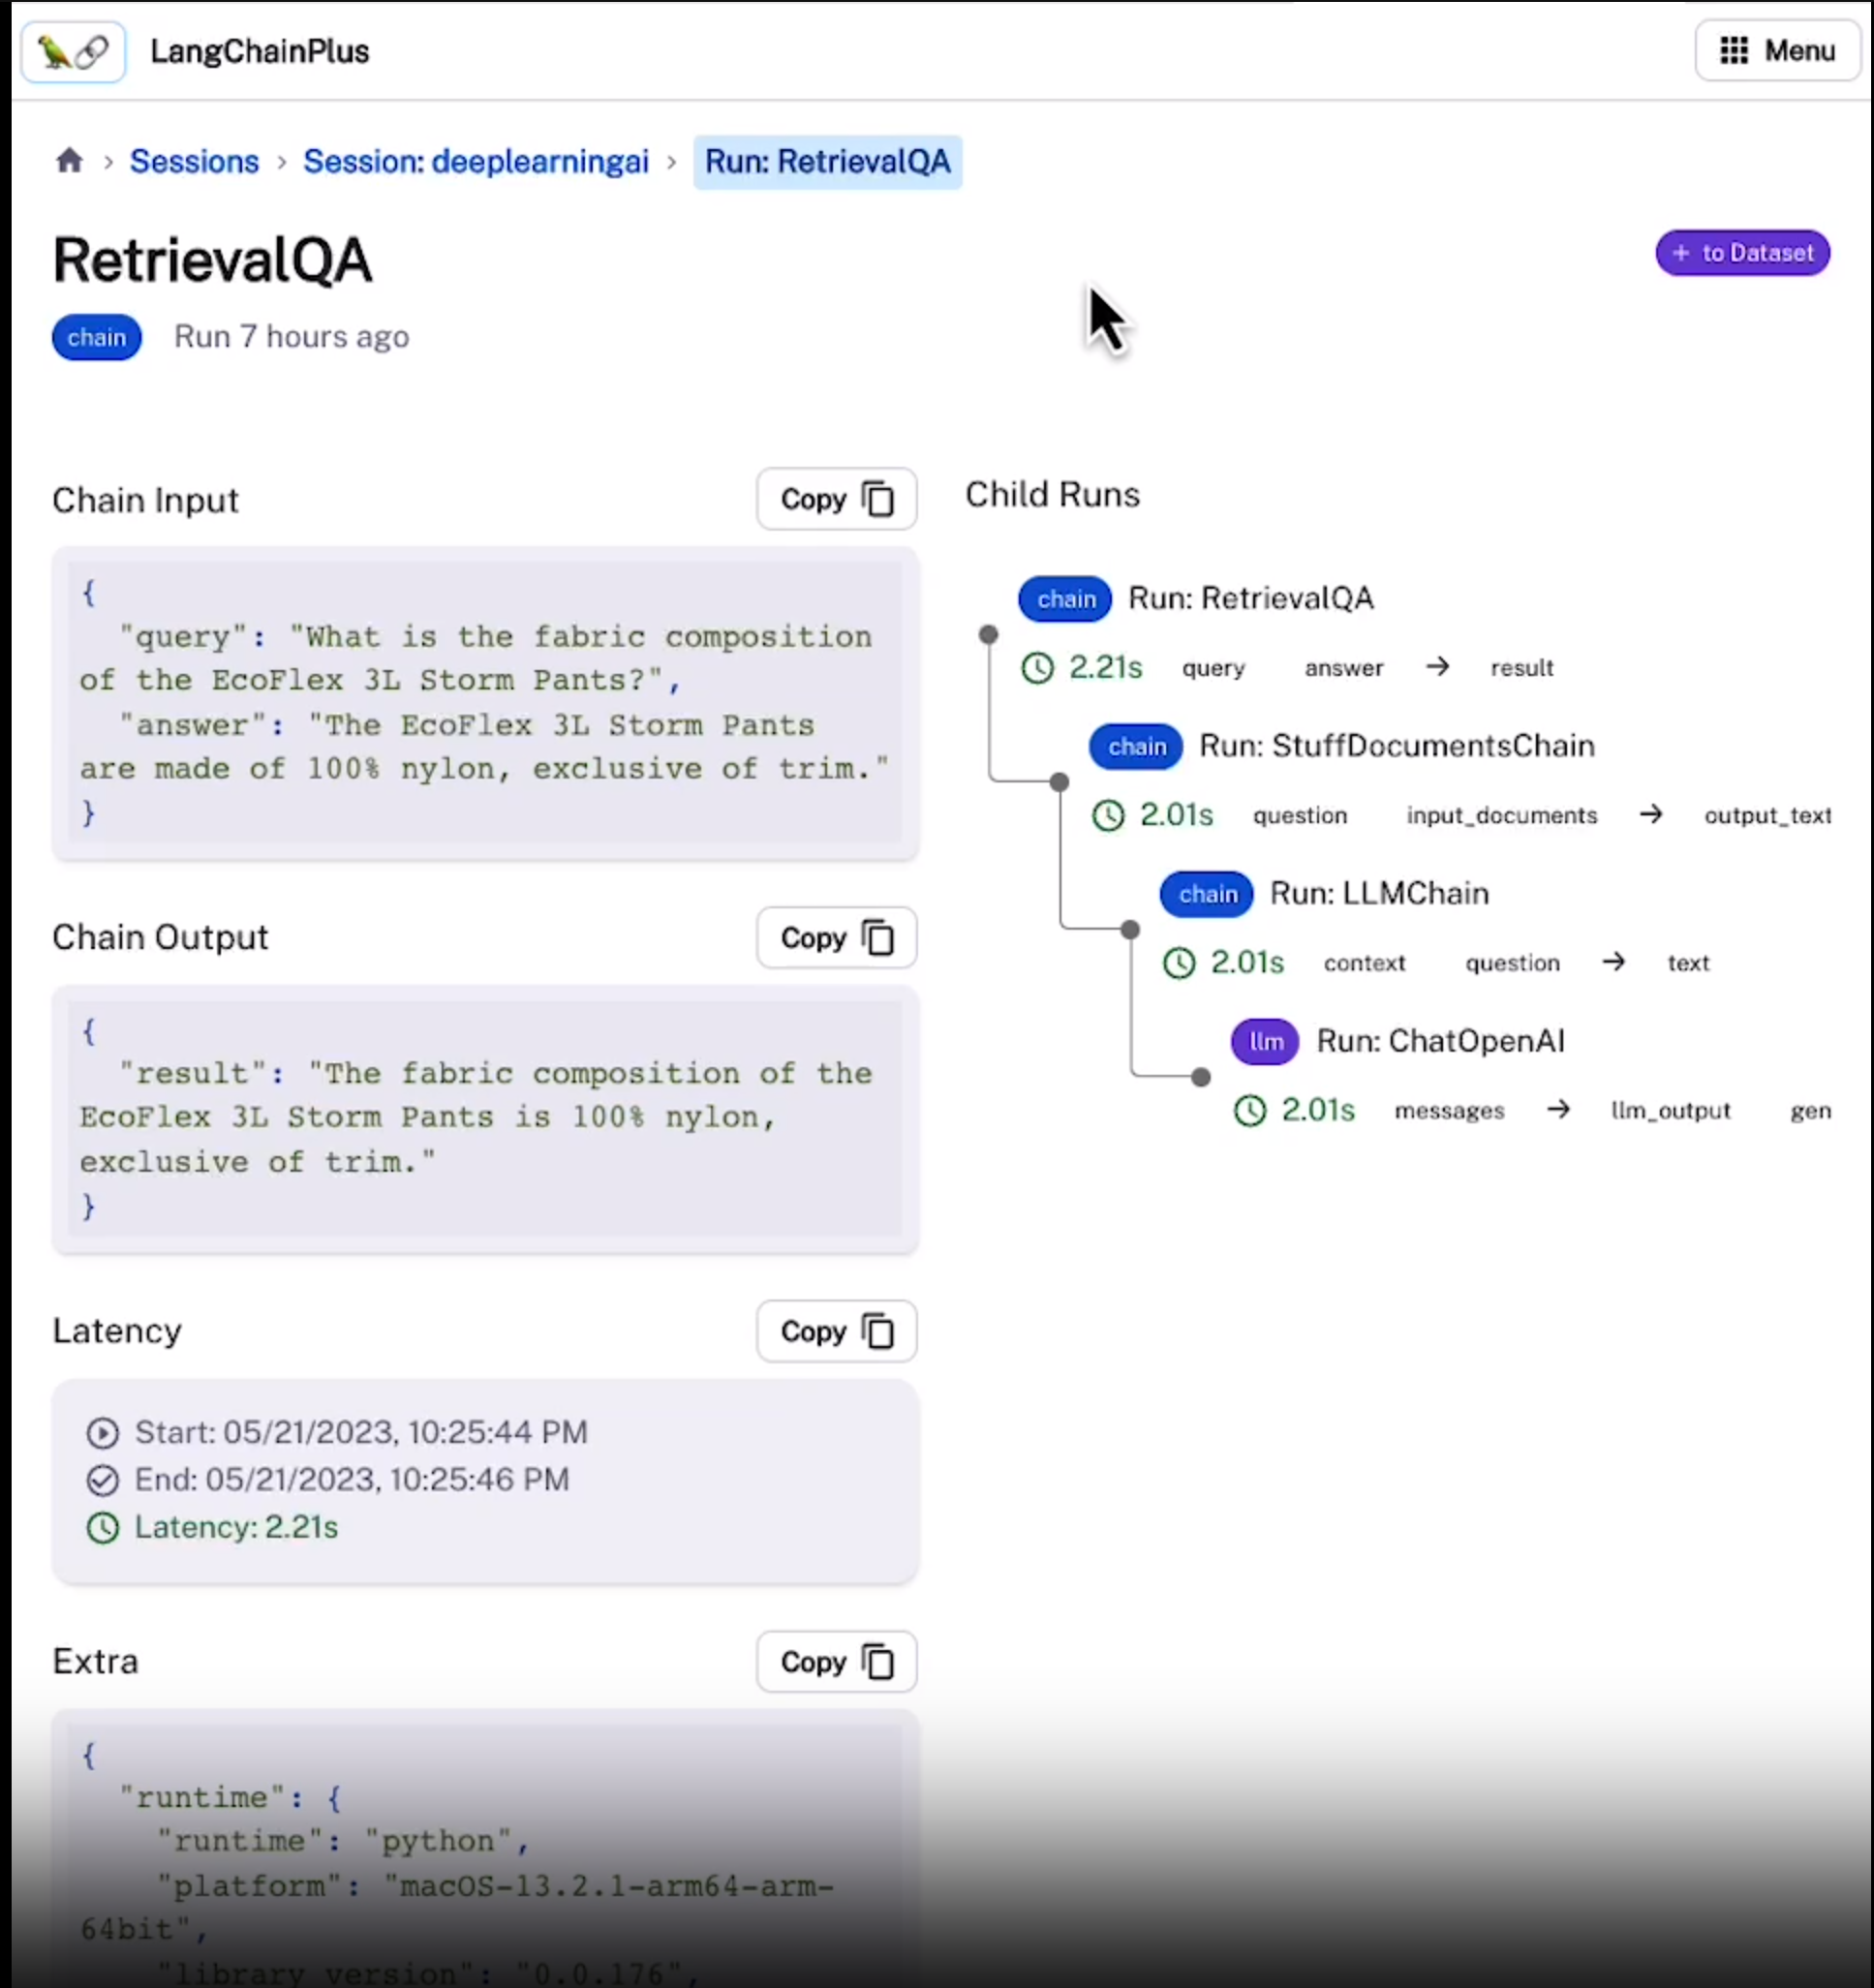

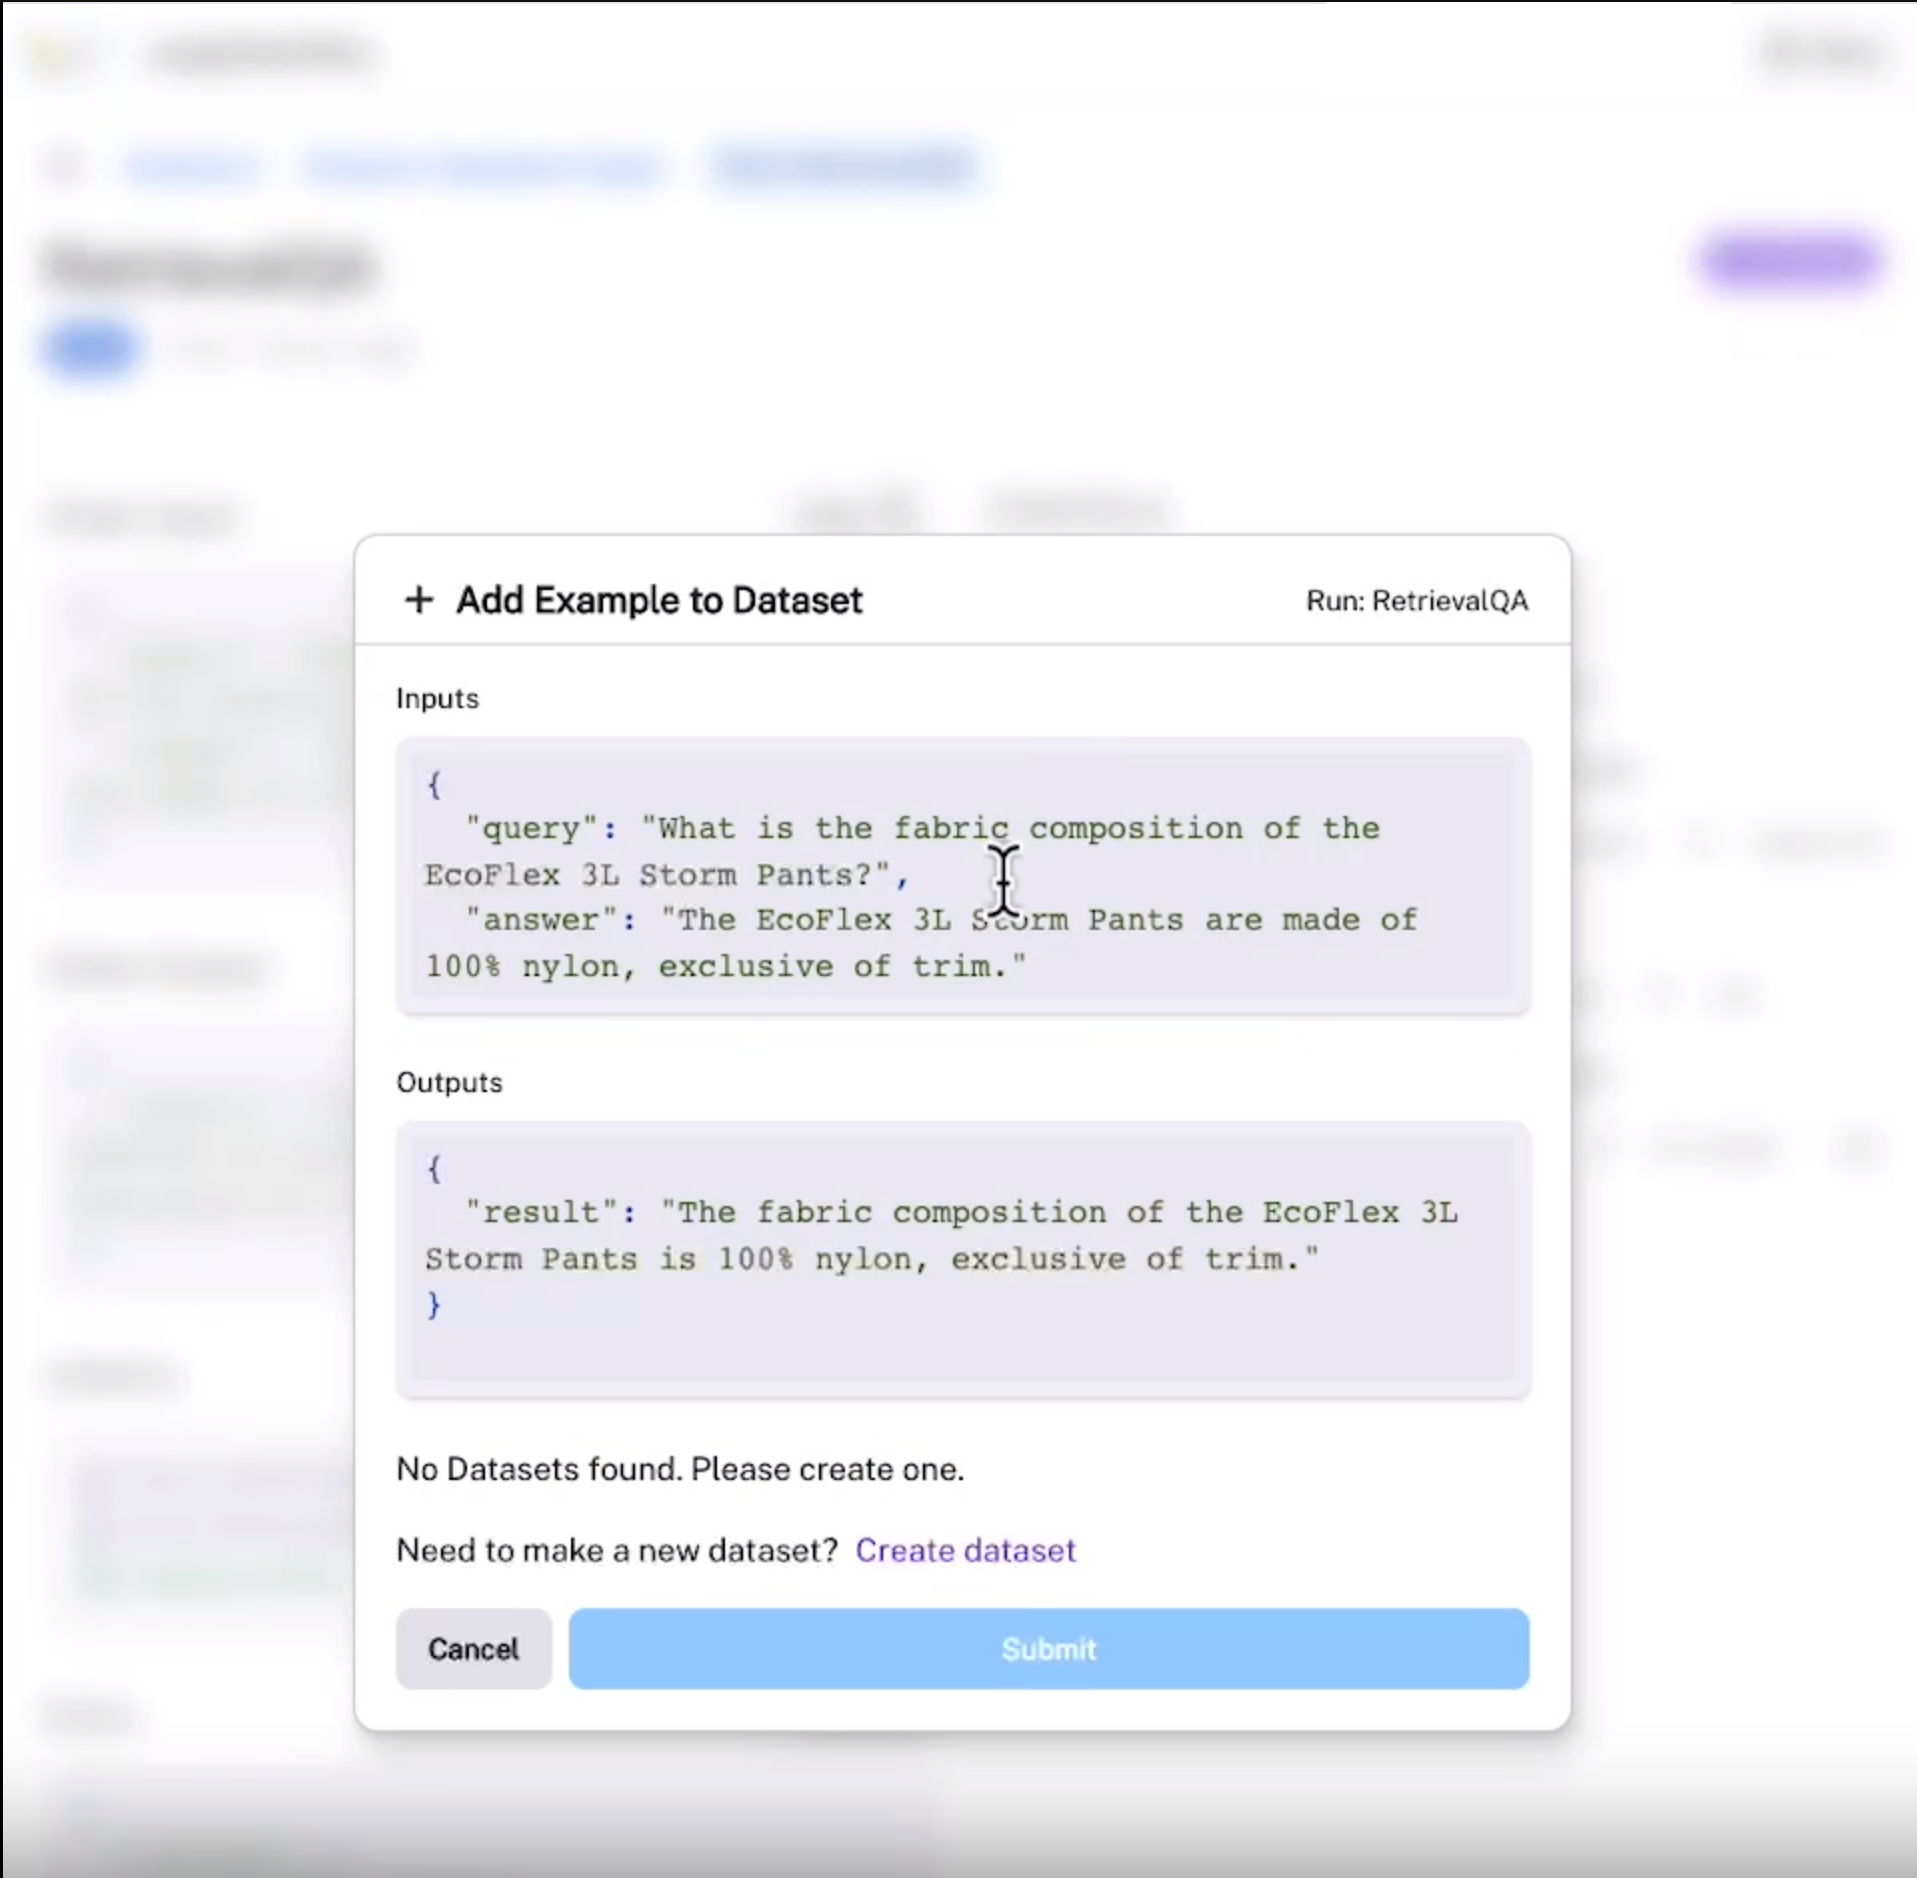